In [1]:
import os
import h5py
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from keras import optimizers
#import VGG16
from keras.applications.vgg16 import VGG16
#import VGG19
from keras.applications.vgg19 import VGG19
#import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
#import InceptionV3
from keras.applications.inception_v3 import InceptionV3
#import Xception
from keras.applications.xception import Xception
#import imagenet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, History

In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [9]:
import tarfile

fname = 'data/car-damage-dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall('data/')
    tar.close()
    

In [10]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    print(f"Image shape: {img.shape}") # show the shape of the image
    return img

Image shape: (194, 259, 3)


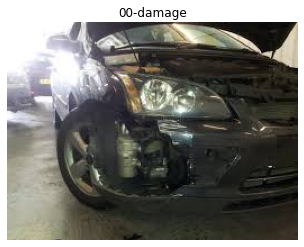

In [11]:
# View a random image 
img = view_random_image(target_dir="data/data1a/training/",target_class="00-damage")

In [12]:
train="data/data1a/training"
test="data/data1a/validation"

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42, subset='training', shuffle = True )

valid_data = test_datagen.flow_from_directory(test,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42, shuffle = True)

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [13]:
#enter name of the model, used only to use as path name for saving weights
#Resnet , #Vgg19
model_chosen = "Vgg16"

#VGG16 - uncomment below code block to use VGG16 model
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

#VGG19 - uncomment below code block to use VGG19 model
###

# base_model = tf.keras.applications.VGG19(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224, 224, 3)
# )

###

#Resnet - uncomment below code block to use Resnet50 model
###

# base_model = ResNet50(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224, 224, 3)
# )

###

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

# Fit the model 
history = model.fit(train_data, epochs=10, steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

58900480/58889256 [==============================] - 8s 0us/step
Epoch 1/10
58/58 [==============================] - 122s 2s/step - loss: 0.4509 - accuracy: 0.7913 - val_loss: 0.2462 - val_accuracy: 0.9022
Epoch 2/10
58/58 [==============================] - 115s 2s/step - loss: 0.2710 - accuracy: 0.8837 - val_loss: 0.2285 - val_accuracy: 0.9130
Epoch 3/10
58/58 [==============================] - 118s 2s/step - loss: 0.1733 - accuracy: 0.9348 - val_loss: 0.2252 - val_accuracy: 0.9130
Epoch 4/10
58/58 [==============================] - 116s 2s/step - loss: 0.1437 - accuracy: 0.9473 - val_loss: 0.2039 - val_accuracy: 0.9152
Epoch 5/10
58/58 [==============================] - 116s 2s/step - loss: 0.1145 - accuracy: 0.9614 - val_loss: 0.2037 - val_accuracy: 0.9109
Epoch 6/10
58/58 [==============================] - 118s 2s/step - loss: 0.0946 - accuracy: 0.9690 - val_loss: 0.2077 - val_accuracy: 0.9109
Epoch 7/10
58/58 [==============================] - 118s 2s/step - loss: 0.0865 - accurac

In [15]:
save_path = "saved_checkpoints/" + model_chosen + "_car_damage_or_not_detection-model.h5"

model.save(save_path)

In [16]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
    
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def pred_and_plot(model, filename):
    
    #Import the target image and preprocess it
    
    img = load_and_prep_image(filename)

    #Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    pred=pred.round()
    if pred==0:
        pred_class="Damage"
    else:
        pred_class="No Damage"  
    
    #Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

In [31]:
target_dir="data/data1a/training/"

target_class="01-whole"

target_folder = target_dir+target_class
random_image = random.sample(os.listdir(target_folder), 1)[0]

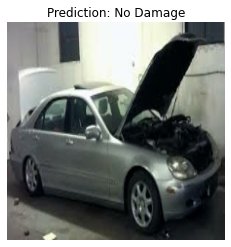

In [32]:
# Test our model 
pred_and_plot(model, target_folder + "/" + random_image)

In [ ]:

test_data = test_datagen.flow_from_directory(test,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42, shuffle = False)

In [39]:
prediction = model.predict(test_data)

In [42]:
min(prediction)

array([5.666884e-07], dtype=float32)

In [52]:
y_pred = []
for each in prediction:
    y_pred.append(np.round(each.item()))

In [66]:
conf_matrix = confusion_matrix(y_pred=y_pred, y_true=valid_data.labels)

array([[123, 107],
       [123, 107]], dtype=int64)

[Text(0, 0.5, 'Damage'), Text(0, 1.5, 'Whole')]

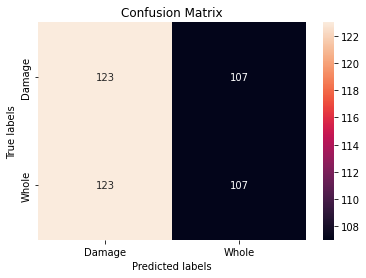

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Damage', 'Whole']); ax.yaxis.set_ticklabels(['Damage', 'Whole'])

In [68]:
print(classification_report(y_true=valid_data.labels, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.50      0.53      0.52       230
           1       0.50      0.47      0.48       230

    accuracy                           0.50       460
   macro avg       0.50      0.50      0.50       460
weighted avg       0.50      0.50      0.50       460

